In [188]:
%matplotlib inline
import numpy as np
from skimage import draw
from scipy import signal
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [199]:
def wiener(y, h, S=1, N=0.1):
    """
    2D Wiener deconvolution. Implemented as defined in
    https://en.wikipedia.org/wiki/Wiener_deconvolution
    
    Parameters
    ----------
    y : 2D array
        The observed signal
    
    h : 2D array
        The impulse response (point spread function) of the system
    
    S : scalar or 2D array, optional
        This signal is used to calclate the power spectral density of the origininal signal.
    
    N : scalar or 2D array, optional
        This signal is used to calclate the power spectral density of the noise.
    
    Returns
    -------
    x : 2D array
        An estimate of the original signal.
    """
    
    shape = [sy + sh - 1  for sy, sh in zip(y.shape, h.shape)]
    widths = [[s // 2] for s in h.shape]
    y = np.pad(y, widths, mode='constant', constant_values=0)
    Y = np.fft.rfft2(y, shape)
    H = np.fft.rfft2(h, shape)
    if not np.isscalar(N):
        N = np.absolute(np.fft.rfft2(N, shape))**2
    if not np.isscalar(S):
        S = np.absolute(np.fft.rfft2(S, shape))**2
    G = (np.conj(H) * S) / (np.absolute(H)**2 * S + N)
    X = G * Y
    shape_original = [sy - sh + 1  for sy, sh in zip(y.shape, h.shape)]
    x = np.fft.irfft2(X, shape)[:shape_original[0],:shape_original[1]].copy()
    return x

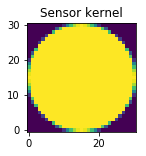

In [212]:
sensor_diameter = 31

radius = sensor_diameter // 2
sensor_function = np.zeros((sensor_diameter, sensor_diameter))
r, c, val = draw.circle_perimeter_aa(radius, radius, radius)
sensor_function[r, c] = val
r, c, = draw.circle(radius, radius, radius)
sensor_function[r, c] = 1
sensor_function /= sensor_function.sum()

plt.figure(figsize=(2,2))
plt.imshow(sensor_function, origin='lower')
plt.title("Sensor kernel");

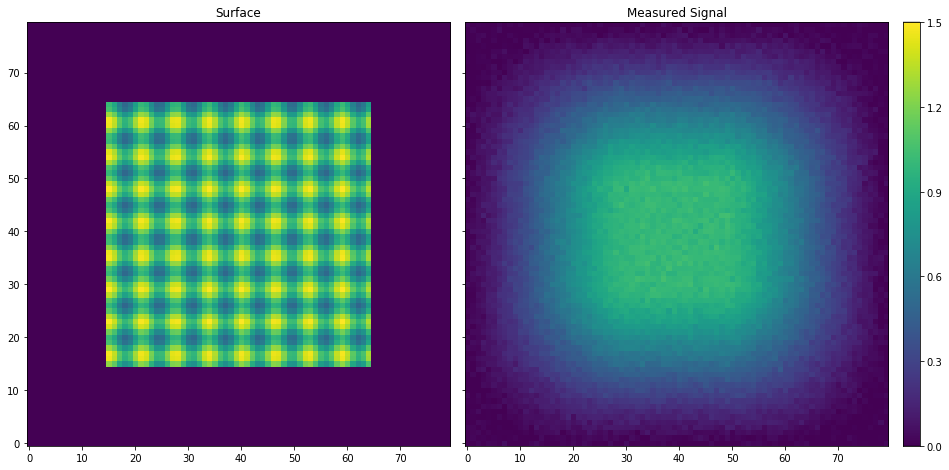

In [215]:
x, y = np.mgrid[0:50, 0:50]
surface = 0.25 * (np.sin(1 * x) + np.cos(1 * y) + 2) + 0.5
pad_widths = [[s // 2] for s in sensor_function.shape]
surface = np.pad(surface, pad_widths, mode='constant', constant_values=0)

measured_signal = signal.convolve2d(surface, sensor_function, mode='same')
noise = np.random.normal(0, 0.02, measured_signal.shape)
measured_signal += noise

fig = plt.figure(figsize=(16, 8))
axes = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.2, share_all=True,
                 cbar_location="right", cbar_mode="single", cbar_size="4%", cbar_pad=0.2)
im1 = axes[0].imshow(surface, origin='lower', vmin=surface.min(), vmax=surface.max())
im2 = axes[1].imshow(measured_signal, origin='lower', vmin=surface.min(), vmax=surface.max())
axes[0].set_title("Surface")
axes[1].set_title("Measured Signal")
axes[1].cax.colorbar(im1)
axes[1].cax.toggle_label(True)

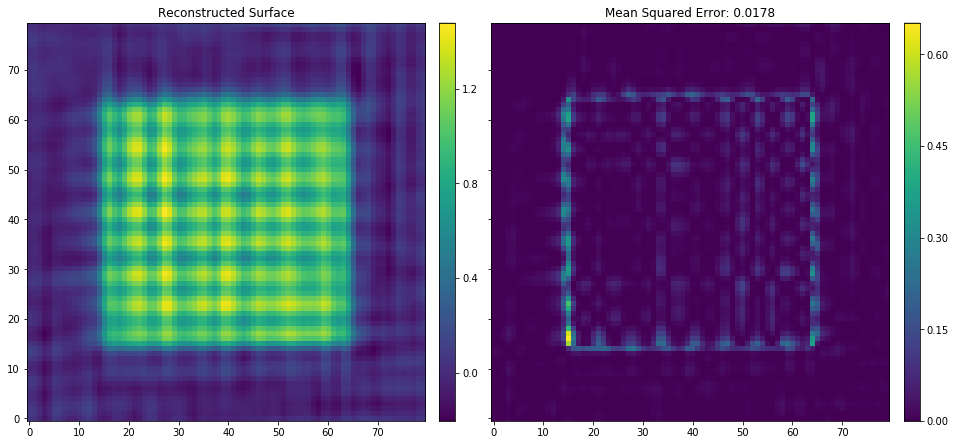

In [217]:
reconstruced_surface = wiener(measured_signal, sensor_function, surface, noise)
error = (reconstruced_surface - surface)**2

fig = plt.figure(figsize=(16, 8))
axes = ImageGrid(fig, 111, nrows_ncols=(1,2), axes_pad=0.5, share_all=True,
                 cbar_location="right", cbar_mode="each", cbar_size="4%", cbar_pad=0.2)
im0 = axes[0].imshow(reconstruced_surface, origin='lower')
im1 = axes[1].imshow(error, origin='lower')
axes[0].set_title("Reconstructed Surface")
axes[0].cax.colorbar(im0)
axes[0].cax.toggle_label(True)

axes[1].set_title("Mean Squared Error: {:.3}".format(error.mean()))
axes[1].cax.colorbar(im1)
axes[1].cax.toggle_label(True)